# Forecasting Covid-19 metrics using Prophet

![Covid-19](https://storage.googleapis.com/kaggle-datasets-images/2633044/4504149/9e9842d99500b5ffcc68cb43c81e4970/dataset-cover.jpg?t=2022-11-13-15-51-56)

## Introduction
The COVID-19 pandemic has presented unprecedented challenges across the globe, affecting millions of lives and putting immense pressure on healthcare systems. One of the key struggles for healthcare providers and policymakers has been the efficient allocation and distribution of medical resources to manage and mitigate the impact of the virus. Accurate forecasting of COVID-19 trends, such as case counts, hospitalization rates, and resource needs, is crucial for planning and response efforts. This notebook aims to address this need by leveraging the Prophet forecasting tool to predict future COVID-19 metrics based on historical data.

## Objective
The primary objective of this analysis is to build a robust forecasting model that can predict future trends in COVID-19 related metrics. By focusing on specific outcomes such as daily case counts and hospitalization rates, we aim to provide actionable insights that can help in the preparedness and optimization of healthcare resources. The forecasts generated by our model will serve as a valuable tool for healthcare providers, policymakers, and public health officials in their decision-making processes.

## Dataset Overview
The covid_19_clean_complete.csv dataset provides a daily record of COVID-19 cases across various countries and regions, with the following structure:

- **Province/State:** Subnational entity; contains null values for countries without province/state data.
- **Country/Region:** National entity.
- **Lat/Long:** Geographic coordinates.
- **Date:** Date of the record.
- **Confirmed:** Cumulative number of confirmed COVID-19 cases.
- **Deaths:** Cumulative number of deaths due to COVID-19.
- **Recovered:** Cumulative number of recovered COVID-19 cases.
- **Active:** Number of active COVID-19 cases.
- **WHO Region:** The World Health Organization region classification.

The dataset contains 49,068 entries with ten features.

## Methodology Overview
To achieve our forecasting objective, we will employ the Prophet tool, developed by Facebook (now Meta). Prophet is designed for forecasting time series data with strong seasonal effects and is particularly suited for daily, weekly, and yearly patterns. Its flexibility in handling missing data, outliers, and incorporating holidays and special events makes it an ideal choice for modeling the complex dynamics of the COVID-19 pandemic. Through this notebook, we will guide you through the process of data loading, preprocessing, exploratory data analysis, model building, forecasting, and evaluation.

##Analysis Plan
The analysis will proceed in structured stages, starting with data preprocessing to prepare the dataset for modeling. We will conduct an exploratory data analysis to understand the trends and patterns within the data. Following this, we will dive into the forecasting model's setup and training, employing Prophet to capture the underlying trends and seasonality in COVID-19 metrics. We will evaluate the model's performance through visual and statistical metrics, aiming to refine and improve our forecasts.

Through this notebook, we aim not only to provide accurate forecasts but also to demonstrate the application of time series forecasting techniques in addressing real-world problems. Our detailed explanations at each stage will ensure that readers gain a comprehensive understanding of the forecasting process and the rationale behind our methodological choices.



In [ ]:
# installing required libs
! python -m pip install prophet pystan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.0 MB/s eta 0:00:00


# Notebook Import Setup

In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Prophet for forecasting
from prophet import Prophet

#Additional display settings to imporve readablility
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)


#importing utility functions
from prophet_utils import clean_dataframe, validate_active_cases, remove_duplicates, plot_cumulative_trends, plot_daily_changes

# Data Importing and Pre-processing

In [ ]:
! mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d meirnizri/covid19-dataset

 86% 4.00M/4.66M [00:00<00:00, 6.12MB/s]
100% 4.66M/4.66M [00:00<00:00, 5.03MB/s]


In [ ]:
!unzip covid19-dataset.zip

Archive:  covid19-dataset.zip
  inflating: Covid Data.csv          


In [ ]:
# read the data and print the first few rows
covid_data = pd.read_csv('covid_19_clean_complete.csv')
covid_data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


In [ ]:
covid_data.shape

(49068, 10)

In [ ]:
covid_data.dtypes

Province/State     object
Country/Region     object
Lat               float64
Long              float64
Date               object
Confirmed           int64
Deaths              int64
Recovered           int64
Active              int64
WHO Region         object
dtype: object

In [ ]:
covid_data.describe()

,Lat,Long,Confirmed,Deaths,Recovered,Active
count,49068.000000,49068.000000,4.906800e+04,49068.000000,4.906800e+04,4.906800e+04
mean,21.433730,23.528236,1.688490e+04,884.179160,7.915713e+03,8.085012e+03
std,24.950320,70.442740,1.273002e+05,6313.584411,5.480092e+04,7.625890e+04
min,-51.796300,-135.000000,0.000000e+00,0.000000,0.000000e+00,-1.400000e+01
25%,7.873054,-15.310100,4.000000e+00,0.000000,0.000000e+00,0.000000e+00
50%,23.634500,21.745300,1.680000e+02,2.000000,2.900000e+01,2.600000e+01
75%,41.204380,80.771797,1.518250e+03,30.000000,6.660000e+02,6.060000e+02
max,71.706900,178.065000,4.290259e+06,148011.000000,1.846641e+06,2.816444e+06


In [ ]:
#check of any presence of nulls in dataset
covid_data.isnull().sum()

Province/State    34404
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
Active                0
WHO Region            0
dtype: int64

# Initial Data Summary
- The `Province/State` field has a significant number of missing values (34,404), likely due to many countries reporting data only at the national level.
- All other columns are complete with no missing values.
- The `Date` column is of type `object`, which implies that it should be converted to datetime for any time-series analysis.
- The data includes cumulative counts for confirmed cases, deaths, and recoveries, as well as active cases, which will be useful for tracking the progression of the pandemic.

In [ ]:
#clean the dataframe
covid_data = clean_dataframe(covid_data, 'Date', 'Province/State')

In [ ]:
covid_data = validate_active_cases(covid_data)

In [ ]:
covid_data = remove_duplicates(covid_data, ['Country/Region', 'Date'])

In [ ]:
covid_data.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


# Let's Visualize the Data

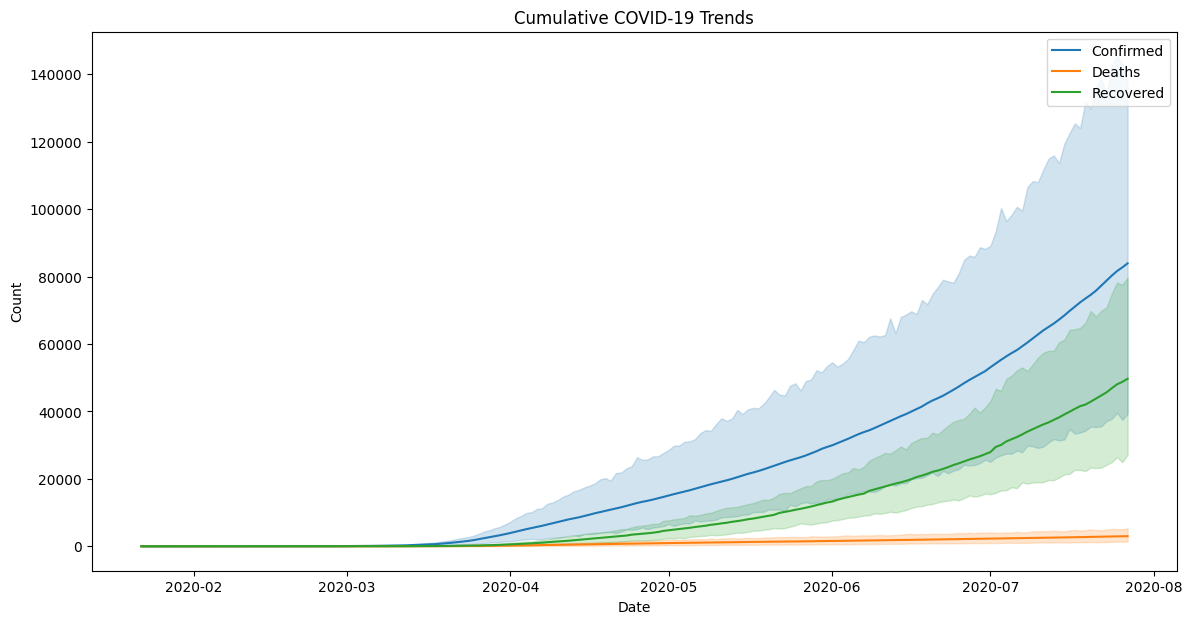

In [ ]:
plot_cumulative_trends(covid_data, 'Date', ['Confirmed', 'Deaths', 'Recovered'], 'Cumulative COVID-19 Trends')

# Interpretation of Cumulative COVID-19 Trends
The graph presents the cumulative counts of confirmed COVID-19 cases, deaths, and recoveries over several months. Here are the key observations we can infer from this graph:

**Confirmed Cases:** The number of confirmed cases shows a continuous and steep upward trend, suggesting that the virus is spreading rapidly without any sign of plateauing during the observed period. The widening of the shaded area around the confirmed cases line indicates increasing uncertainty in the number of confirmed cases over time, which could be due to factors such as changes in testing rates or reporting practices.

**Deaths:** The cumulative deaths also show an upward trend, but the rate of increase is not as steep as the confirmed cases. This could indicate that while the number of cases is growing, the fatality rate may not be increasing at the same pace. However, it's important to note that the actual death count could be influenced by several factors, including improvements in treatment, changes in the population affected, and reporting delays.

**Recoveries:** The recoveries curve is steadily increasing, suggesting that a significant number of individuals are recovering from the virus. However, the slope of the recoveries curve is not as steep as the confirmed cases, indicating that recoveries are not keeping pace with the spread of the virus.

**Comparison of Trends:** The gap between confirmed cases and recoveries is widening, which may point to an increasing number of active cases and potential stress on healthcare systems. The relatively smaller gap between the deaths and recoveries curves indicates that while people are recovering, the death toll is also mounting, albeit at a slower rate than confirmed cases.

**Shaded Regions:** The shaded regions around each line represent the confidence intervals for the respective counts. The broadening of these intervals over time suggests growing variability or uncertainty in the reported data, which could be due to inconsistent testing and reporting policies across different regions.

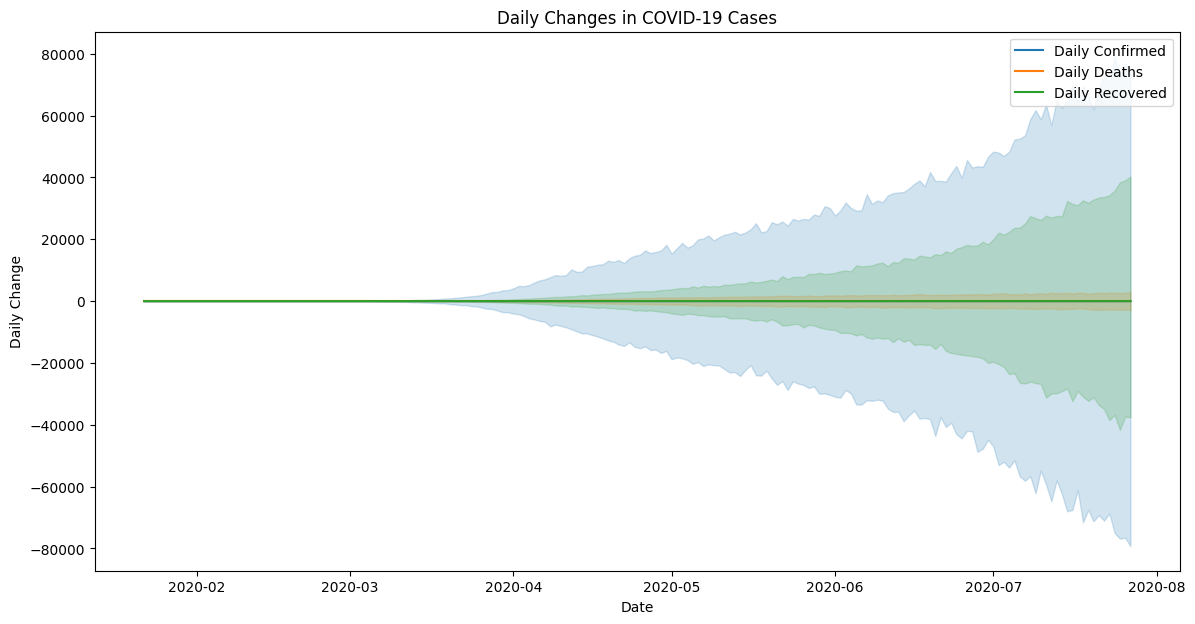

In [ ]:
plot_daily_changes(covid_data, 'Date', ['Confirmed', 'Deaths', 'Recovered'], 'Daily Changes in COVID-19 Cases')

# Interpretation of Daily Changes in COVID-19 Cases with Approximations
This graph illustrates the day-to-day variations in reported COVID-19 metrics:

**Daily Confirmed Cases:** Initially, we see a gentle incline in daily confirmed cases, suggesting a gradual spread. Over time, the frequency and magnitude of spikes increase, with some peaks potentially reaching upwards of 60,000 new cases per day, indicative of intense waves of infection. The shaded area, representing the confidence interval, widens significantly over time, which could reflect growing disparities in daily case reporting.

**Daily Deaths:** The daily deaths appear relatively stable, with the count fluctuating modestly around a mean that could be estimated in the low thousands. Unlike confirmed cases, the variance in daily deaths does not show a dramatic increase, implying a consistent rate of reporting across the timeline.

**Daily Recoveries:** The recoveries show several dips into negative values, which are likely not true decreases but rather adjustments or corrections in the data. There are moments when the recoveries surge, possibly exceeding 20,000 per day, followed by sharp declines, which may reflect batch reporting or changes in the criteria for classifying recoveries.

## Quantitative Observations
At various points, the number of daily confirmed cases shows sharp increases, suggesting possible outbreaks or increased testing and reporting capacity.

Daily deaths, while showing less variability than confirmed cases, do exhibit some peaks and troughs, perhaps correlating with the trajectory of confirmed cases with a time lag.

The recovered cases graph includes several anomalous data points, where the counts drop below zero, likely indicating retrospective data corrections rather than actual decreases in recovery numbers.

# Introduction to Time Series Forecasting Model Prophet

Prophet is a time series forecasting tool developed by Facebook's Core Data Science team. It's designed for forecasting at scale, accommodating the common issues encountered in business time series data, such as missing values, outliers, and shifts in trends. Prophet is open-source and available in both Python and R, making it accessible to a wide range of users.

Prophet stands out for its ability to handle data with strong seasonal patterns and for its ease of use, requiring minimal tuning to produce high-quality forecasts. It's also robust to the effects of holidays and is capable of working with daily, weekly, and yearly seasonality, as well as custom seasonality cycles.

### Why Choose Prophet?
- **Ease of Use:** Prophet requires no prior knowledge of time series models, making it suitable for analysts with varying levels of expertise.
- **Flexibility:** It can accommodate unusual holidays and events, and it automatically detects changes in trends, adjusting the forecast to account for these shifts.
- **Robustness:** Prophet is designed to handle missing data and outliers gracefully, which are common in real-world time series datasets.
- **Interpretability:** The model components (trend, seasonality, holidays) are easy to understand, and the tool provides intuitive visualizations.
- **Scalability:** Prophet is optimized for performance and can handle a large number of forecasts, making it suitable for applications with many time series.

### Mathematical Framework of Prophet
Prophet uses a decomposable time series model with three main components:

- **Trend:** The trend component models non-linear growth trends over time, allowing for saturation growth modeling or piecewise linear growth with automatic changepoint detection.
- **Seasonality:** The seasonality component uses Fourier series to provide a flexible model of periodic changes due to weekly and yearly seasonality.
- **Holidays/Events:** The holiday component is a binary indicator (0 or 1) reflecting the impact of holidays and events.
The model is formulated as:

<p align='center'>
  y(t) = g(t) + s(t) + h(t) + e<sub>t</sub>
</p>

Where:
- y(t) is the predicted value.
- g(t) represents the trend function, which models non-periodic changes.
- s(t) covers periodic changes (seasonality).
- h(t) represents the effects of holidays or events.
- e<sub>t</sub> is the error term.

#### Trend Component
The trend g(t) is modeled with a piecewise linear or logistic growth curve, allowing the trend to change over time. Prophet automatically detects points (changepoints) where the rate of growth changes and can be influenced by specifying the number of changepoints or their locations.

#### Seasonality Component
The seasonality s(t) is modeled using Fourier series, which can approximate cyclical patterns of any frequency. Prophet can include multiple seasonalities: daily, weekly, yearly, etc., by adding these Fourier series together.

#### Holiday Component
The holiday h(t) uses an indicator function that adds a flexible effect on specified dates, such as holidays or events, which can be irregular.

#### Error Term
The error term e<sub>t</sub> captures any idiosyncratic changes that are not accommodated by the model.

These components allow Prophet to model complex behaviors in time series data, making it an excellent choice for a variety of business and research applications. Its component-based nature also means that each piece can be inspected, understood, and explained, which adds a level of interpretability often missing from other forecasting methods.

For detailed documentation, tutorials, and additional resources on Prophet, you can visit the official website and documentation hosted on [Prophet's GitHub page](https://facebook.github.io/prophet/).


# Dataset Preparation and Model Fitting

In [ ]:
df_covid = covid_data.rename(columns={'Date':'ds', 'Confirmed': 'y'})

In [ ]:
#initializing the model
model = Prophet()
model.fit(df_covid)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp33jo9qed/en3r1cdn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp33jo9qed/bz1wlh0r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90645', 'data', 'file=/tmp/tmp33jo9qed/en3r1cdn.json', 'init=/tmp/tmp33jo9qed/bz1wlh0r.json', 'output', 'file=/tmp/tmp33jo9qed/prophet_model6moziw2b/prophet_model-20240215002938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:29:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:29:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

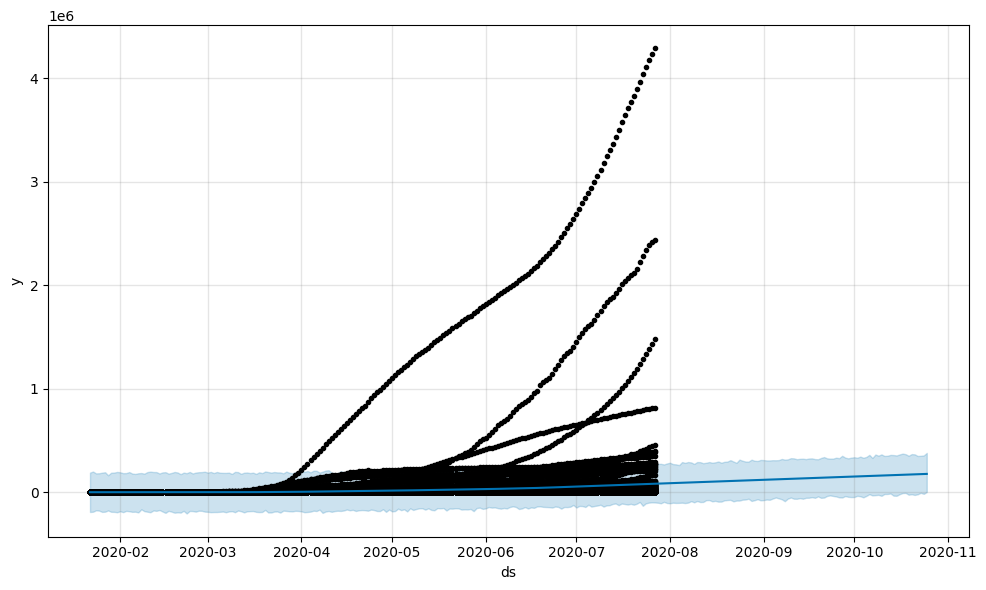

In [ ]:
# Plotting the forecast
fig1 = model.plot(forecast)
fig1.show()

# Interpretation of the Prophet Forecast Plot
The forecast plot generated by the Prophet model provides a visual representation of the model's understanding of the historical data and its projection into the future:

**Historical Data (`Black Dots`):** The dense clustering of black dots at the lower part of the graph represents the historical data points. The concentration suggests a period of relatively stable cases with minimal fluctuation in the early stages.

**Model Fit to Historical Data (`Dark Line`):** The solid dark line that closely follows the black dots indicates the model's fit to the historical data. The fit appears to be tight and suggests that the model has been able to capture the underlying trend within the historical data effectively.

**Forecast (`Dotted Line`):** The dotted line extending beyond the historical data represents the model's forecast. There are several trajectories forecasted by the model, each representing a potential future scenario based on the trends learned from the historical data. The divergence in these lines indicates multiple potential future paths for the data, reflecting the model's uncertainty about the future.

**Uncertainty Intervals (`Shaded Area`):** The light shaded area surrounding the forecasted trend lines indicates the uncertainty intervals. The broadening of this area as it extends into the future represents increasing uncertainty in the forecast. This uncertainty may stem from less historical data to inform the forecast, potential volatility in the data, or both.

**Exponential Growth:** The upward trajectory of the forecast suggests that the model expects the trend of confirmed cases to continue increasing, potentially in an exponential fashion. This reflects the model's inference of the growth pattern observed in the historical data.

## Insights and Implications
- **Continued Spread:** The model's forecast indicates an expectation of continued spread of COVID-19, with no evident plateau or decline in the projected time frame.

- **Planning for Resource Allocation:** The forecast can be used by healthcare systems and policymakers to plan for resource allocation, ensuring that sufficient infrastructure, medical equipment, and personnel are in place to manage the anticipated case load.

- **Uncertainty in Long-term Projections:** The increasing uncertainty in the long-term projections underscores the inherent difficulties in accurately predicting the course of a pandemic. This variability must be considered when using such forecasts for decision-making.

- **Potential for Intervention:** While the forecast shows a concerning upward trend, it is not deterministic. Public health interventions, such as increased vaccination rates, social distancing measures, and mask mandates, can alter the trajectory of the pandemic and should be factored into policy decisions.

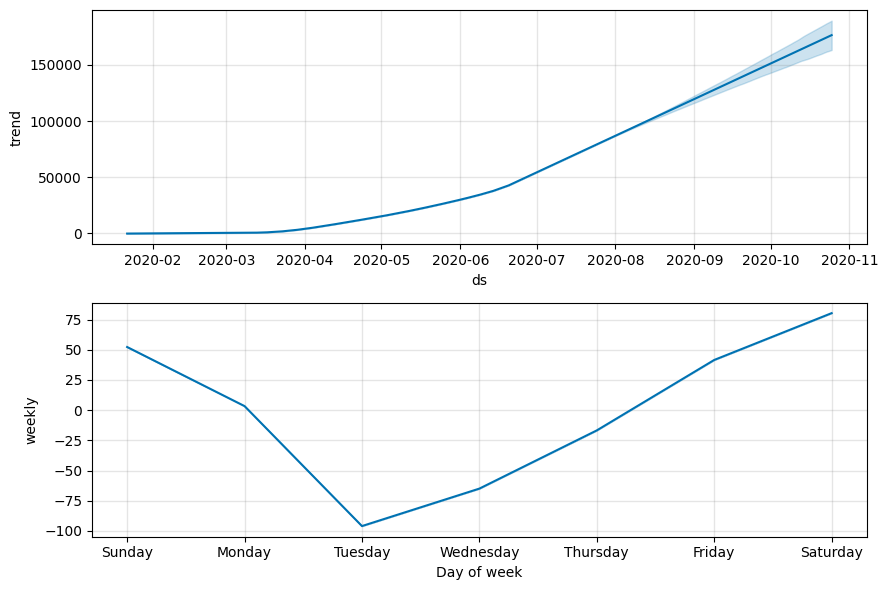

In [ ]:
# Plotting the components of the forecast
fig2 = model.plot_components(forecast)
fig2.show()


# Trend Component
The top graph depicts the trend component of the dataset:

**Upward Trend:** The line represents the underlying trend of the data, which shows a consistent increase over time. The absence of plateaus or declines suggests that the number of cases (assuming the data represents case counts) has been continuously rising throughout the period observed.

**Confidence Interval:** The shaded region around the trend line represents the model's uncertainty about the trend. The fact that this region expands slightly as it moves into the future indicates increased uncertainty in the projections. However, the relatively narrow confidence interval suggests that the model is fairly confident in the continuity of the trend at least in the near term.

# Weekly Seasonality Component
The bottom graph shows the weekly seasonality of the dataset:

**Weekly Pattern:** The line indicates the average effect of each day of the week on the number of cases. The trend shows that there is a significant dip early in the week, with the lowest point around Tuesday. This might reflect reporting delays during weekends, leading to lower reported numbers on Monday or Tuesday due to the closure of testing facilities or administrative offices.

**End of Week Increase:** The graph shows an increase in cases towards the end of the week, peaking around Friday or Saturday. This could be due to a catch-up effect from the earlier dip, where case reporting accelerates as the week progresses.

## Inferences and Implications
**Continuous Growth:** The persistent upward trend suggests that, without significant intervention or changes in the spread of the disease, the situation is expected to worsen over time. This could indicate the need for increased public health interventions to curb the spread.

**Reporting Patterns:** The weekly seasonality pattern may be indicative of reporting cycles rather than actual fluctuations in transmission, which is a critical insight for public health officials to consider when interpreting the data.

**Policy and Communication:** Understanding these patterns can help in planning and communication, ensuring that the public and health professionals are aware that lower numbers at the start of the week may not necessarily signify a decrease in case numbers.